In this notebook we will modulate and transmit QAM symbols using OFDM. The transmit signal will be sent through a frequency selective channel, modeled as a *tapped delay line* channel. Even though this channel is frequency selective, OFDM make the channel appears flat at each subcarrier, although each subcarrier has a different channel gain that we will need to compensate. This compensasion is equivalent to a 1-tap equalizer and its simplicity is one of the main OFDM advantages.

## Initializations

First we do some initializations and import some packages we will use.

In [1]:
%matplotlib notebook

In [2]:
import sys
sys.path.append('/home/darlan/cvs_files/pyphysim/')
import math
import numpy as np
from matplotlib import pyplot as plt
from pyphysim import channels
from pyphysim.channels.fading import TdlChannel, COST259_RAx
from pyphysim.channels.fading_generators import JakesSampleGenerator
from pyphysim.modulators import OFDM, QAM, PSK
from pyphysim.modulators.ofdm import OfdmOneTapEqualizer
from pyphysim.util.misc import randn_c

## Simulation Parameters

Now we can set the simulation parameters.

In [3]:
M = 16  # Size of the modulation constelation
noise_var = 0#1e-3
bandwidth = 5e6    # 20 MHz bandwidth
Fd = 10             # Doppler frequency (in Hz)
Ts = 1./bandwidth  # Sampling interval
fft_size = 1024
num_used_subcarriers = 600
num_ofdm_symbols = 10
num_symbols = num_ofdm_symbols * num_used_subcarriers
cp_size = 10

## Perform the Simulation

Now we can create the QAM and OFDM objects and generate the transmit signal.

In [4]:
# Creates the required objects
qam = QAM(M)
ofdm = OFDM(fft_size, cp_size, num_used_subcarriers)

# Generate some random data
data = np.random.randint(0,M, num_symbols)

# Modulate the data
qam_symbols = qam.modulate(data)

# OFDM Modulate the QAM symbols
ofdm_symbols = ofdm.modulate(qam_symbols)

Let's see the QAM symbols in a scatter plot. Since the symbols were not corrupted yet all symbols should only be one of the 16 possible symbols in the QAM-16 constellation. Also, note that the mean power of the symbols is close to 1.

<IPython.core.display.Javascript object>


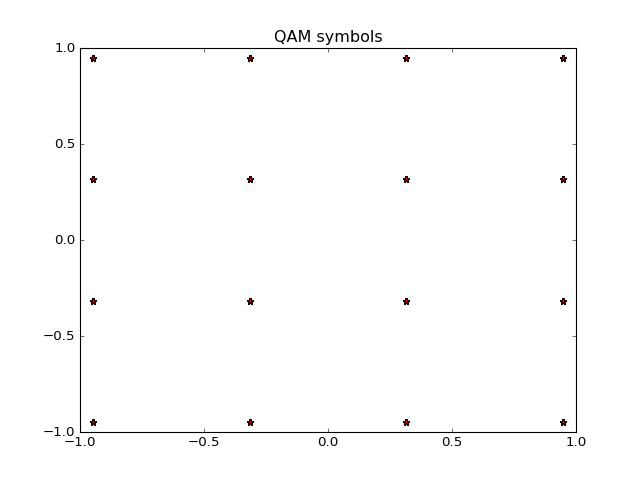

Mean symbol power: 0.999866666667


In [5]:
plt.figure()
plt.plot(np.real(qam_symbols), np.imag(qam_symbols), 'r*')
plt.title('QAM symbols')
# The QAM symbols have an average power equal to 1.0
print("Mean symbol power: {0}".format(np.mean(np.abs(qam_symbols)**2)))

plt.show()

We can also plot the OFDM modulated data.

<IPython.core.display.Javascript object>


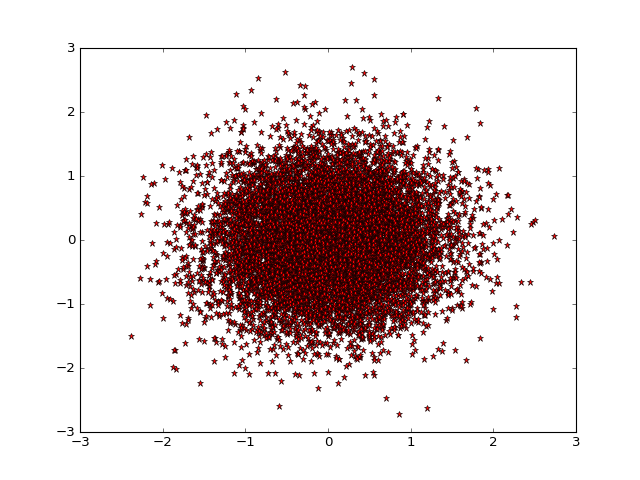

Mean symbol power: 0.982695270123


In [6]:
plt.figure()
plt.plot(np.real(ofdm_symbols), np.imag(ofdm_symbols), 'r*')

# The power is divided among all subcarriers. 
# The whole OFMD still has an average power equal to 1.0.
print("Mean symbol power: {0}".format(
        np.mean(np.abs(ofdm_symbols)**2)))

plt.show()

In [7]:
# Create a jakes object with 20 rays. 
# This will be passed to the TDL channel object.
jakesObj = JakesSampleGenerator(Fd, Ts, L=20)
tdlchannel = TdlChannel(jakesObj, COST259_RAx)

In [8]:
# Transmit the ofdm modulated signal through the TDL channel
received_ofdm_symbols = tdlchannel.corrupt_data(ofdm_symbols)

received_ofdm_symbols += math.sqrt(noise_var) * randn_c(
    received_ofdm_symbols.size)

In [9]:
# OFDM Demodulate received data (the last samples corresponding 
# only to channel memory are not included)
ofdm_demodulated_data = ofdm.demodulate(
    received_ofdm_symbols[0:ofdm_symbols.size])

ofdm_demodulated_data = np.reshape(ofdm_demodulated_data, [-1, num_used_subcarriers], order='C')

received_ofdm_symbol1 = ofdm_demodulated_data[0]
received_ofdm_symbol2 = ofdm_demodulated_data[1]

## Plot the data of the first 2 received OFDM symbols

Note that it is not correct and does not appear like the QAM symbols we want.

<IPython.core.display.Javascript object>


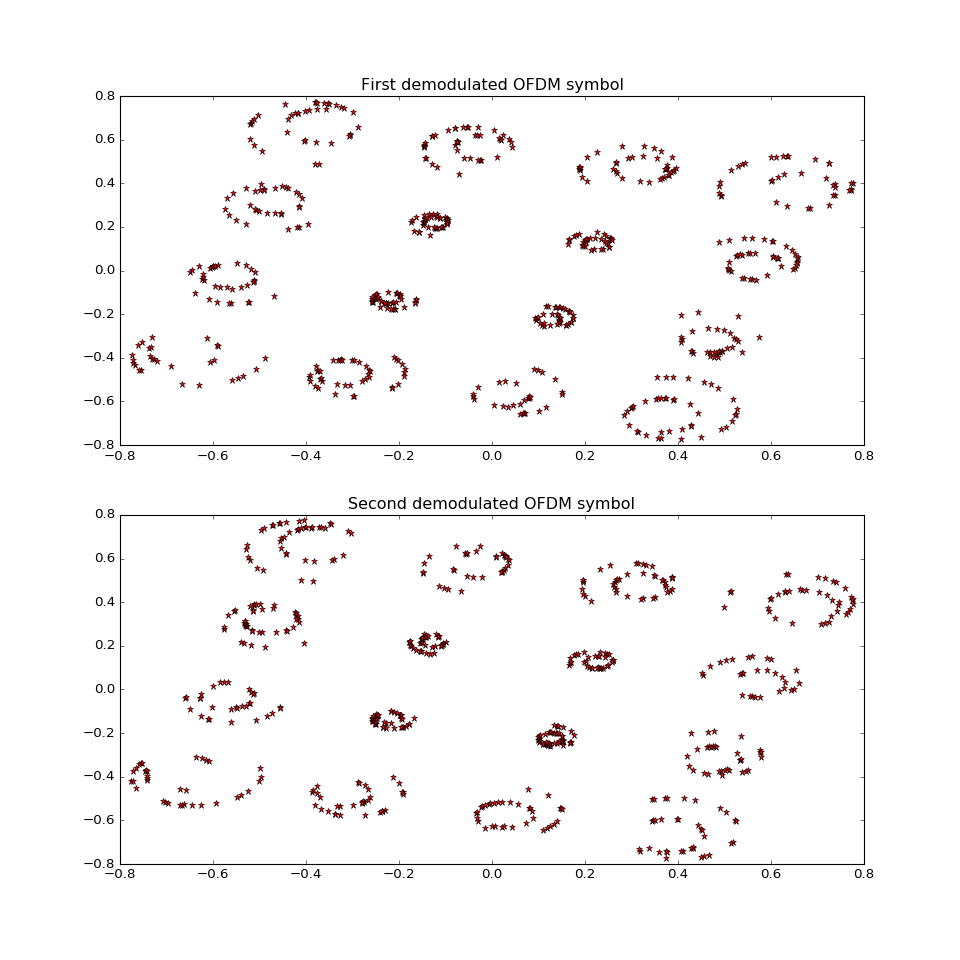

In [10]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.plot(np.real(received_ofdm_symbol1), np.imag(received_ofdm_symbol1), 'r*')
plt.title('First demodulated OFDM symbol')

plt.subplot(2,1,2)
plt.plot(np.real(received_ofdm_symbol2), np.imag(received_ofdm_symbol2), 'r*')
plt.title('Second demodulated OFDM symbol')
plt.show()

## Perform the one-tap equalization

First we get the frequence response at each subcarrier. This will be sligtly different for each OFDM symbol due to channel variation in time. In fact, it varies even during the transmission of a single OFDM symbol, but we are simulating for a low dopper frequency value. We will thus average the frequency response during the transmission of a single OFDM symbol.

Let's plot the average frequency response in different OFDM symbols to visualize the channel variation.

<IPython.core.display.Javascript object>


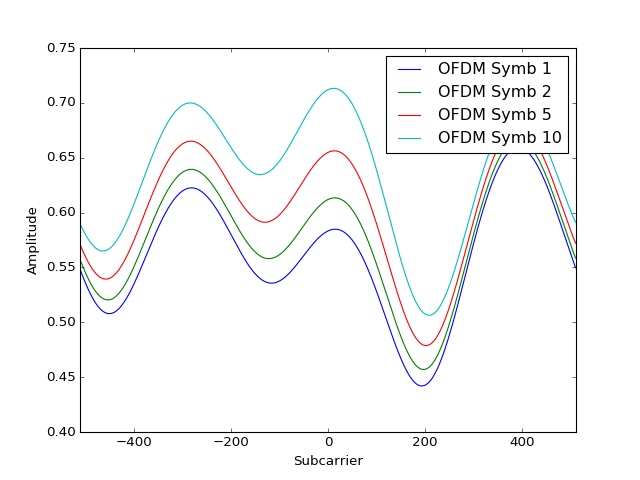

In [11]:
# Plot the channel mean frequency response that the different OFDM symbols perceived
impulse_response = tdlchannel.get_last_impulse_response()
freq_response = impulse_response.get_freq_response(fft_size)
freq_response = np.reshape(freq_response, (fft_size, num_ofdm_symbols, -1))
mean_freq_response = np.mean(freq_response, axis=2)
subcarrier_idx = np.arange(-fft_size//2, fft_size//2)
plt.figure()
plt.plot(subcarrier_idx, np.abs(mean_freq_response[:,0]))
plt.hold(True)
plt.plot(subcarrier_idx, np.abs(mean_freq_response[:,2]))
plt.plot(subcarrier_idx, np.abs(mean_freq_response[:,5]))
plt.plot(subcarrier_idx, np.abs(mean_freq_response[:,-1]))
plt.legend(['OFDM Symb 1', 'OFDM Symb 2', 'OFDM Symb 5', 'OFDM Symb 10'])
plt.xlabel('Subcarrier')
plt.ylabel('Amplitude')
plt.xlim([-fft_size//2,fft_size//2])
plt.show()

Now let's perform the one-tap equalization. For that we define the equalize function below.

In [12]:
# This function can perform the one-tap-equalization
def equalize(ofdm_obj, data, impulse_response):
    freq_response = impulse_response.get_freq_response(fft_size)

    print(freq_response.shape)
    # Reshape and get the average frequency response for all samples in each OFDM symbol
    freq_response = np.reshape(freq_response, (fft_size, num_ofdm_symbols, -1))
    mean_freq_response = np.mean(freq_response, axis=2)

    # Apply the fftshift so that we have the frequency response at the correct locations (natural order)
    #mean_freq_response = np.fft.fftshift(mean_freq_response, axes=0)
    mean_freq_response_T = mean_freq_response.T
    
    num_unused_subcarriers = fft_size - num_used_subcarriers
    
    equalized_ofdm_demodulated_data = data / \
        mean_freq_response_T[:, ofdm_obj._get_used_subcarrier_indexes_proper()]
    #mean_freq_response_T[:, num_unused_subcarriers//2:-num_unused_subcarriers//2]
    
    equalized_ofdm_demodulated_data = equalized_ofdm_demodulated_data.flatten()
    return equalized_ofdm_demodulated_data

# impulse_response = tdlchannel.get_last_impulse_response()
# equalized_ofdm_demodulated_data = equalize(ofdm, ofdm_demodulated_data, impulse_response)

# plt.figure(figsize=(8,8))
# plt.plot(np.real(equalized_ofdm_demodulated_data), np.imag(equalized_ofdm_demodulated_data), 'r*')
# plt.title('QAM symbols transmitted in the OFDM symbols')
# plt.xlim([-1.15, 1.15])
# plt.ylim([-1.15, 1.15])
# plt.xlabel('Real part')
# plt.ylabel('Imaginary part')
# plt.show()

In [13]:
# Note that in pyphysim we have a class that can perform this one-tap-equalization as well
ofdm_equalizer = OfdmOneTapEqualizer(ofdm)
equalized_ofdm_demodulated_data = ofdm_equalizer.equalize_data(ofdm_demodulated_data, impulse_response)

In the plot we can clearly see that now we have the correct QAM symbols.

<IPython.core.display.Javascript object>


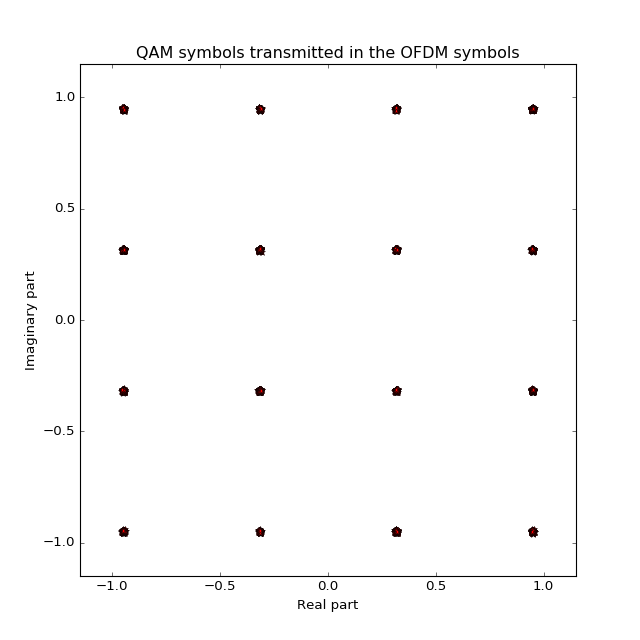

In [14]:
plt.figure(figsize=(8,8))
plt.plot(np.real(equalized_ofdm_demodulated_data), np.imag(equalized_ofdm_demodulated_data), 'r*')
plt.title('QAM symbols transmitted in the OFDM symbols')
plt.xlim([-1.15, 1.15])
plt.ylim([-1.15, 1.15])
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.show()

Let's compute the symbol error rate.

In [15]:
received_data = qam.demodulate(equalized_ofdm_demodulated_data)

# Compare received data with transmitted data
ser = 1 - np.sum(data == received_data) / data.size
print("Symbol Error Rate: {0}".format(ser))

Symbol Error Rate: 0
